In [1]:
# %pip install --upgrade pip wheel setuptools black isort jupyterlab-code-formatter jupyterthemes jupyterlab_darkside_theme nvitop
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install --upgrade tensorboard accelerate flash-attn torchtnt bitsandbytes transformers
# %pip install torcheval torchmetrics torchtnt
# !rm ~/.cache/matplotlib -rf

In [5]:
import os
import pickle
from collections import defaultdict
from gc import collect
from glob import glob
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm


def _collect():
    print(collect())
    torch.cuda.empty_cache()


# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 8 weeks
n_out = 8
resample_period = "1W"
dataset_type = "df_sales"
max_zeros_in_sku = 0.9

In [6]:
%matplotlib inline

In [7]:
col_to_remove = [
    "amt_disc_ea",
    "amt_gross",
    "amt_net",
    "amt_net_forex",
    "canceled",
    "class_code",
    "code",
    "color_code",
    "cost_center",
    "created_at",
    "currency",
    "customer_code",
    "deleted_at",
    "department_code",
    "discount_granted_excl",
    "discountflag",
    "document_currency",
    "document_number",
    "document_type",
    "family_code",
    "filename",
    "flag_delete",
    "gender_code",
    "geography",
    "gl_account",
    "gl_devise",
    "gl_etablissement",
    "gl_model",
    "gl_numero",
    "gl_numligne",
    "gl_puht",
    "gl_refartbarre",
    "gl_remiseligne",
    "gl_tiers",
    "gl_totalht",
    "gp_refexterne",
    "division",
    "group_code",
    "id",
    "id_class",
    "id_collection",
    "id_color",
    "id_department",
    "id_family",
    "id_gender",
    "id_group",
    "id_loader_job",
    "id_subclass",
    "libdim1",
    "pays",
    "price_ea",
    "product_id",
    "rate",
    "rn",
    "subclass_code",
    "upc",
]

In [20]:
def load_raw_df(
    glob_filter: str = "df_sales*.parquet",
    columns_rename: dict = {
        "gl_datepiece": "date",
        "gl_codearticle": "sku",
        "gl_qtefact": "qty",
    },
):
    df: pd.DataFrame = pd.concat([pd.read_parquet(f) for f in glob(glob_filter)])
    # Removing unuseful columns
    [df.pop(col) for col in col_to_remove if col in df]
    # Renaming columns
    df = df.reset_index(drop=True).rename(columns=columns_rename)

    df["date"] = pd.to_datetime(df["date"])
    df = df.convert_dtypes()

    # Strip text data
    for column in df.select_dtypes(include=[pd.StringDtype]).columns:
        df[column] = df[column].str.strip()

    # Removing null/wrong SKUs - data cleaning on qty
    df = df[~df["sku"].isna()]
    df = df[df["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]
    df = df[df["qty"] > 0]

    df["sales_type"] = (
        glob_filter.split("*")[0] if "*" in glob_filter else glob_filter.split(".")[0]
    )
    return df

In [5]:
raw_dataset_fname = "raw_dataset.parquet"

if os.path.exists(raw_dataset_fname):
    df = pd.read_parquet(raw_dataset_fname)
    # Retain only cegid sales
    df = df[df["sales_type"] == "df_sales"]
    dataset_type = "_".join(df["sales_type"].unique())
    del df["sales_type"]
    if "date" in df:
        df.set_index("date", inplace=True)
    df = df.copy()
else:
    df_cl1 = load_raw_df(
        "cl1_sales*.parquet",
        {"posting_date": "date", "product_color": "sku", "quantity": "qty"},
    )
    df_sales = load_raw_df(
        "df_sales*.parquet",
        {"gl_datepiece": "date", "gl_codearticle": "sku", "gl_qtefact": "qty"},
    )
    df = pd.concat([df_sales, df_cl1])
    df.sort_values("date", inplace=True)
    df.to_parquet(raw_dataset_fname, compression="brotli")
    df.set_index("date", inplace=True)

# Feature engineering
#### Time
 - Decompose in `t_sin` and `t_cos`
#### Seasons
 - Split `market_seasons` by `|` and concat with `seasons`, `market_season`, `season`
#### Sizes
 - Split `sizes` by `|` and concat with `size`
#### Channels
 - Split `channels` by `|` and concat with `channel`
#### Brands
 - Split `brands` by `|` and concat with `brand`
#### Collections
 - Split `collections` by `|` and concat with `collections`

In [8]:
def get_features(df: pd.DataFrame, col_feature: str):
    features = []
    # Filtering all columns that contains our `col_feature` target
    cols = [col for col in df if col_feature in col]
    for col in cols:
        unique_values = [v for v in df.pop(col).unique() if not pd.isnull(v)]

        for value in unique_values:
            features.extend([v.strip() for v in value.split("|")])
    features = [f for f in list(set(features)) if len(f) > 0]
    df[col_feature] = [features for _ in range(len(df))]

In [9]:
raw_ts_fname = f"raw_timeseries_{dataset_type}_{resample_period}.parquet"
if os.path.exists(raw_ts_fname):
    series = pd.read_parquet(raw_ts_fname)
    if "date" in series:
        series.set_index("date", inplace=True)
else:
    series_list = []
    for sku, _df in tqdm(df.groupby("sku")):
        agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
        _series = _df.resample(resample_period).agg(agg).ffill().bfill()
        [
            get_features(_series, feature)
            for feature in ["size", "season", "channel", "brand", "collection"]
        ]
        series_list.append(_series)
    series = pd.concat(series_list).sort_index()
    series.to_parquet(raw_ts_fname, compression="brotli")

In [10]:
mask = series.isna().any(axis=1)
print(
    f"Removing {len(series.loc[mask, 'sku'].unique())} SKU that does not have categorical data [{mask.sum()}] weeks]"
)
series = series[~mask].copy()

Removing 976 SKU that does not have categorical data [22983] weeks]


In [11]:
def create_timeseries(X, cat, y, window=10, n_out=1, shift=0):
    _X, _cat, _y = [], [], []
    for i in range(len(X) - (window + n_out + shift)):
        _X.append(X[i : i + window])
        _cat.append(cat[i])
        _y.append(y[i + window + shift : i + window + shift + n_out])
    return np.asarray(_X), np.asarray(_cat), np.asarray(_y)


print(np.asarray(range(10)))
_x, _cat, _y = create_timeseries(
    np.asarray(range(10)), np.asarray(range(10)), np.asarray(range(10)), 3, 1, 0
)
_x.shape, _cat.shape, _y.shape, _x, _cat, _y

[0 1 2 3 4 5 6 7 8 9]


((6, 3),
 (6,),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([0, 1, 2, 3, 4, 5]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [12]:
# Removing SKUs that do not have at least:
# - 1 example for train and 1 for test
# - 90% of empty data

skus_to_remove = (
    series.groupby("sku")
    .filter(
        lambda x: len(x) <= (window + n_out + 2)
        or (x["qty"] == 0).sum() / len(x) >= max_zeros_in_sku
    )["sku"]
    .unique()
)
mask = series["sku"].isin(skus_to_remove)
_percent_sku_removed = round(len(skus_to_remove) / len(series["sku"].unique()) * 100, 2)
_percent_entries_removed = round(mask.sum() / len(mask) * 100, 2)
print(
    f"Removing {_percent_sku_removed}% of SKUs [{_percent_entries_removed}% total entries]"
)
series = series[~mask].copy()

Removing 62.06% of SKUs [48.71% total entries]


<Axes: xlabel='date'>

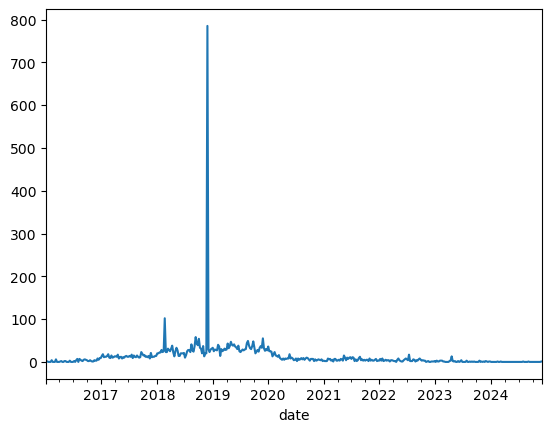

In [13]:
data = series[series["sku"] == "MWL150E-00139-100"]["qty"]
data.plot()

In [14]:
def remove_outliers(data: pd.Series) -> (pd.Series, bool):
    # Calculate Z-scores
    mean = data.mean()
    std = data.std()
    data_zscore = (data - mean) / std

    # Identify outliers (e.g., |Z| > 3)
    outliers_z = data[abs(data_zscore) > 3]
    has_outliers = len(outliers_z) > 0
    clip_data = None
    if has_outliers:
        clip_data = data.clip(upper=mean + 3 * std, lower=mean - 3 * std)

    return clip_data, has_outliers

In [15]:
max_value = series["qty"].max()
for dtype in [np.float16, np.float32, np.float64]:
    if max_value <= np.finfo(dtype).max:
        print(f"Setting dtype: {dtype}")
        series["qty"] = series["qty"].astype(dtype)
        break

Setting dtype: <class 'numpy.float16'>


In [16]:
n_outliers = 0
filtered_ts_fname = (
    f"filtered_timeseries_{dataset_type}_{resample_period}_{max_zeros_in_sku}.parquet"
)
if os.path.exists(filtered_ts_fname):
    series = pd.read_parquet(filtered_ts_fname)
else:
    for sku in tqdm(series["sku"].unique()):
        mask = series["sku"] == sku
        data, has_outliers = remove_outliers(series.loc[mask, "qty"])
        if has_outliers:
            n_outliers += 1
            series.loc[mask, "qty"] = data
    print(f"Removed {n_outliers} outliers")
    series = series.convert_dtypes()
    series.to_parquet(filtered_ts_fname, compression="brotli")

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=42)  # 4 cluster (bin)
series["bins"] = kmeans.fit_predict(series[["qty"]])

# Creating categorical features

In [18]:
categorical_features = [
    c for c in series.columns if c not in {"sku", "qty", "description", "bins"}
]
categorical_features

['composition',
 'gender_description',
 'department_description',
 'class_description',
 'group_description',
 'color_description',
 'family_description',
 'subclass_description',
 'size',
 'season',
 'channel',
 'brand',
 'collection']

In [19]:
label_encoders = {c: MultiLabelBinarizer() for c in categorical_features} | {
    "bins": LabelBinarizer()
}
label_encoders

{'composition': MultiLabelBinarizer(),
 'gender_description': MultiLabelBinarizer(),
 'department_description': MultiLabelBinarizer(),
 'class_description': MultiLabelBinarizer(),
 'group_description': MultiLabelBinarizer(),
 'color_description': MultiLabelBinarizer(),
 'family_description': MultiLabelBinarizer(),
 'subclass_description': MultiLabelBinarizer(),
 'size': MultiLabelBinarizer(),
 'season': MultiLabelBinarizer(),
 'channel': MultiLabelBinarizer(),
 'brand': MultiLabelBinarizer(),
 'collection': MultiLabelBinarizer(),
 'bins': LabelBinarizer()}

In [20]:
for column, label_encoder in tqdm(label_encoders.items()):
    label_encoder.fit(series[column].reset_index(drop=True))
    series[f"encoded_{column}"] = label_encoder.transform(
        series[column].reset_index(drop=True)
    ).tolist()
    # series[f"encoded_{column}"] = ''

  0%|          | 0/14 [00:00<?, ?it/s]

In [21]:
sku_to_index = {sku: idx for idx, sku in enumerate(series["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)

<Axes: xlabel='date'>

<Axes: xlabel='date'>

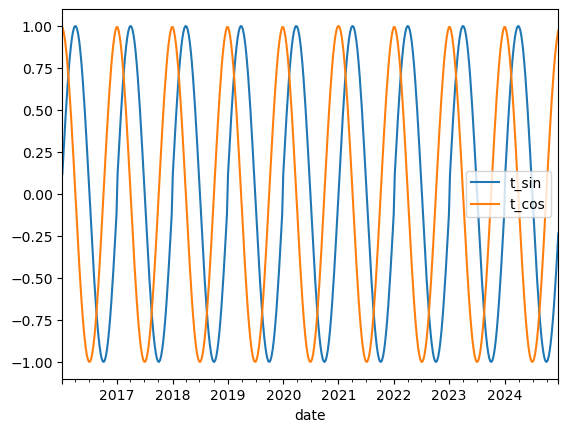

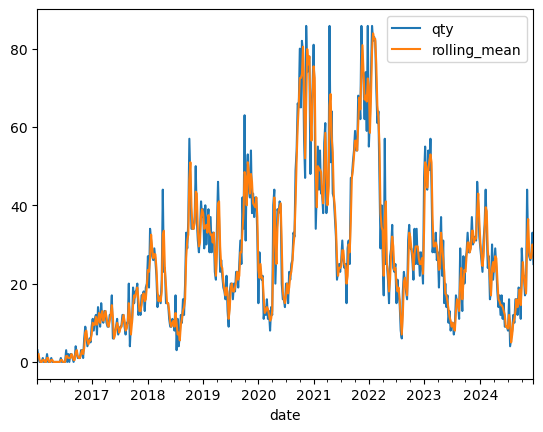

In [22]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-52 i think), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.
calendar = series.index.isocalendar().week
series["t_sin"] = np.sin(calendar * (2 * np.pi / calendar.max()))
series["t_cos"] = np.cos(calendar * (2 * np.pi / calendar.max()))

display(series[series["sku"] == "MJQ008H-00535-461"][["t_sin", "t_cos"]].plot())
t = series[series["sku"] == "MJQ008H-00535-461"][["qty"]]
t["rolling_mean"] = t["qty"].rolling(2).mean()
t.plot()

In [23]:
sku_list = series.pop("sku")

In [25]:
encoded_categorical_features = [c for c in series.columns if "encoded" in c]
series_fname = f"series_{dataset_type}_{max_zeros_in_sku}_with_bins.pkl"
if os.path.exists(series_fname):
    with open(series_fname, "rb") as f:
        (
            ts_train_x_dataset,
            ts_train_cat_dataset,
            ts_train_y_dataset,
            ts_test_x_dataset,
            ts_test_cat_dataset,
            ts_test_y_dataset,
        ) = pickle.load(f)
else:
    ts_train_x_dataset = []
    ts_train_cat_dataset = []
    ts_train_y_dataset = []
    ts_test_x_dataset = []
    ts_test_cat_dataset = []
    ts_test_y_dataset = []
    grouped = series.groupby("sku_code")
    series_features = [
        "qty",
        "sku_code",
        "t_sin",
        "t_cos",
    ]
    for idx, (sku, _series) in enumerate(tqdm(grouped)):
        categorical_data = (
            _series[encoded_categorical_features]
            .iloc[0]
            .apply(lambda x: np.asarray(x, dtype=np.bool_))
            .values
        )

        _ts, _cat, _y = create_timeseries(
            _series[series_features],
            [categorical_data] * len(_series),
            _series[["qty", "encoded_bins"]],
            window=window,
            n_out=n_out,
        )

        _ts_train, _ts_test, _cat_train, _cat_test, _y_train, _y_test = (
            train_test_split(_ts, _cat, _y, test_size=0.2, shuffle=False)
        )
        ts_train_x_dataset.extend(_ts_train)
        ts_test_x_dataset.extend(_ts_test)
        ts_train_cat_dataset.extend(_cat_train)
        ts_test_cat_dataset.extend(_cat_test)
        ts_train_y_dataset.extend(_y_train)
        ts_test_y_dataset.extend(_y_test)
    ts_train_x_dataset = np.asarray(ts_train_x_dataset)
    ts_train_y_dataset = np.asarray(ts_train_y_dataset)
    ts_train_cat_dataset = np.asarray(ts_train_cat_dataset)
    ts_test_x_dataset = np.asarray(ts_test_x_dataset)
    ts_test_y_dataset = np.asarray(ts_test_y_dataset)
    ts_test_cat_dataset = np.asarray(ts_test_cat_dataset)
    with open(series_fname, "wb") as f:
        pickle.dump(
            (
                ts_train_x_dataset,
                ts_train_cat_dataset,
                ts_train_y_dataset,
                ts_test_x_dataset,
                ts_test_cat_dataset,
                ts_test_y_dataset,
            ),
            f,
            pickle.HIGHEST_PROTOCOL,
        )
del series
_collect()
ts_train_x_dataset.shape, ts_train_cat_dataset.shape, ts_train_y_dataset.shape

0


((594114, 52, 4), (594114, 14), (594114, 8, 2))

In [26]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler().fit(ts_train_x_dataset[:, :, 0])
scaler_y = StandardScaler().fit(ts_train_y_dataset[:, :, 0])

ts_train_x_dataset[:, :, 0] = scaler_x.transform(ts_train_x_dataset[:, :, 0])
ts_test_x_dataset[:, :, 0] = scaler_x.transform(ts_test_x_dataset[:, :, 0])

ts_train_y_dataset[:, :, 0] = scaler_y.transform(ts_train_y_dataset[:, :, 0])
ts_test_y_dataset[:, :, 0] = scaler_y.transform(ts_test_y_dataset[:, :, 0])

In [27]:
for x, cat, y in zip(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset):
    print(x.shape, [_.shape for _ in cat], y.shape)
    break

(52, 4) [(62,), (12,), (21,), (29,), (25,), (25,), (26,), (37,), (125,), (53,), (7,), (5,), (119,), (15,)] (8, 2)


In [28]:
class DemandDataset(Dataset):
    def __init__(self, raw_dataset, cat_dataset, y):
        self.raw_dataset = raw_dataset
        self.cat_dataset = cat_dataset
        self.y = y

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        return {
            "sequence": self.raw_dataset[idx],
            "y": self.y[idx],
            "categorical_data": self.cat_dataset[idx],
        }

    def collate_fn(self, batch):
        qty = torch.as_tensor(
            np.asarray([x["sequence"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        ).unsqueeze(-1)
        sku = torch.as_tensor(
            np.asarray([x["sequence"][:, 1][0] for x in batch], dtype=np.int32),
            dtype=torch.int32,
        )
        time = torch.as_tensor(
            np.asarray([x["sequence"][:, 2:] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )
        y = torch.as_tensor(
            np.asarray([x["y"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )
        y_cat = []

        for entry in batch:
            y_cat.append(entry["y"][:, 1])

        cats = defaultdict(list)
        for entry in batch:
            v = dict(zip(encoded_categorical_features, entry["categorical_data"]))
            for k, v in v.items():
                cats[k].append(v)
        for k in cats:
            cats[k] = torch.as_tensor(np.asarray(cats[k]), dtype=torch.bool)

        return {
            "qty": qty,
            "sku": sku,
            "time": time,
            "y": y,
            "y_cat": torch.as_tensor(
                np.asarray(y_cat, batch_sizedtype=np.float32), dtype=torch.float32
            ),
            "cats": cats,
        }


_collect()

0


In [29]:
batch_size = 2048
pin_memory = True
num_workers = 2

if not torch.cuda.is_available():
    device = torch.device("cpu")
    pin_memory = False
    num_workers = 0
    batch_size = 32

ds_train = DemandDataset(ts_train_x_dataset, ts_train_cat_dataset, ts_train_y_dataset)
dl_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=ds_train.collate_fn,
    pin_memory=pin_memory,
    drop_last=True,
)

ds_test = DemandDataset(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset)
dl_test = DataLoader(
    ds_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=ds_test.collate_fn,
    pin_memory=pin_memory,
    drop_last=True,
)
if torch.cuda.is_available():
    device = torch.device("cuda")
    from torchtnt.utils.data import CudaDataPrefetcher

    dl_train = CudaDataPrefetcher(dl_train, device, 32)
    dl_test = CudaDataPrefetcher(dl_test, device, 32)

In [30]:
for x_ds in ds_train:
    break
for x_dl in dl_train:
    break

/var/folders/3t/lzf89s9x54n6vrg80qrx5cdm0000gp/T/ipykernel_23938/3817159542.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1733624403138/work/torch/csrc/utils/tensor_new.cpp:281.)
  "y_cat": torch.as_tensor(y_cat, dtype=torch.float32),


In [31]:
encoded_features_shape = {}
for k, v in x_dl.items():
    if k == "cats":
        encoded_features_shape.update(
            {"cats": {k: _v.shape[-1] for k, _v in v.items()}}
        )
    else:
        encoded_features_shape.update({k: v.shape[-1]})
pprint(encoded_features_shape)

{'cats': {'encoded_bins': 15,
          'encoded_brand': 5,
          'encoded_channel': 7,
          'encoded_class_description': 29,
          'encoded_collection': 119,
          'encoded_color_description': 25,
          'encoded_composition': 62,
          'encoded_department_description': 21,
          'encoded_family_description': 26,
          'encoded_gender_description': 12,
          'encoded_group_description': 25,
          'encoded_season': 53,
          'encoded_size': 125,
          'encoded_subclass_description': 37},
 'qty': 1,
 'sku': 32,
 'time': 2,
 'y': 8,
 'y_cat': 15}


In [32]:
def plot_model(model, x_dl):
    from torchviz import make_dot

    qty = x_dl["qty"]
    time = x_dl["time"]
    sku = x_dl["sku"]
    cats = {key: value.int() for key, value in x_dl["cats"].items()}
    _res = model(qty, time, sku, cats)

    make_dot(_res, params=dict(model.named_parameters()))

In [33]:
class DemandForecastingModel(nn.Module):
    def __init__(
        self,
        sku_vocab_size,
        sku_emb_dim,
        cat_features_dim,
        cat_emb_dims,
        time_features_dim,
        hidden_size,
        lstm_layers,
        n_out,
    ):
        super(DemandForecastingModel, self).__init__()
        # SKU Embedding
        self.sku_embedding = nn.Embedding(sku_vocab_size, sku_emb_dim)

        # Categorical Feature Embeddings
        self.cat_embeddings = nn.ModuleDict(
            {
                name: nn.Embedding(vocab_size, emb_dim)
                for name, vocab_size, emb_dim in zip(
                    cat_features_dim.keys(),
                    cat_features_dim.values(),
                    [cat_emb_dims] * len(cat_features_dim),
                )
            }
        )

        # LSTM for time-series data
        self.lstm = nn.LSTM(
            input_size=1 + time_features_dim,  # qty (1) + time (2)
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
        )

        # Fully connected layer for final predictions
        total_cat_emb_dim = cat_emb_dims * len(cat_features_dim) + sku_emb_dim
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + total_cat_emb_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_out),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(hidden_size + total_cat_emb_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, cat_features_shapes["encoded_bins"] * n_out),
        )

    def forward(self, qty, time, sku, cats):
        # SKU Embedding
        sku_emb = self.sku_embedding(sku)  # [batch_size, sku_emb_dim]

        # Categorical Embeddings
        # NOTE: We are using the `mean`, migrate to MaxPool/other smart ways
        cat_embs = [
            emb(cats[name]).mean(axis=1) for name, emb in self.cat_embeddings.items()
        ]

        cat_embs = torch.cat(cat_embs, dim=1)  # [batch_size, total_cat_emb_dim]

        # FIXME: Use an LSTM for the QTY and one for the TIME?

        # Time-Series Data Processing
        x = torch.cat([qty, time], dim=-1)  # Combine qty and time [batch_size, 52, 3]
        lstm_out, _ = self.lstm(x)  # [batch_size, 52, hidden_size]
        # Take the last time step [batch_size, hidden_size]
        lstm_out = lstm_out[:, -1, :]

        # Feature Fusion
        combined_features = torch.cat(
            [lstm_out, sku_emb, cat_embs], dim=-1
        )  # [batch_size, hidden_size + total_cat_emb_dim]

        # Final Prediction
        output = self.fc(combined_features)  # [batch_size, n_out]
        # [batch_size, n_out * num_classes]
        classification_logits = self.fc_class(combined_features)

        # Reshape for classification output: [batch_size, n_out, num_classes]
        classification_output = classification_logits.view(
            -1, n_out, cat_features_shapes["encoded_bins"]
        )

        return output, classification_output

In [43]:
# Validation on the test dataset
def validate_model(model, dataloader, regression_criterion, classification_criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    predictions = []
    actuals = []
    _skus = []
    if device.type == "cuda":
        total_steps = len(dataloader.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader.dataset) // batch_size
    with torch.no_grad():
        for batch in tqdm(dataloader, total=total_steps, leave=False):
            # Move data to the device
            qty = batch["qty"]  # [batch_size, 52, 1]
            time = batch["time"]  # [batch_size, 52, 2]
            sku = batch["sku"]  # [batch_size]
            cats = {
                key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()
            }
            targets = batch["y"]  # [batch_size, n_out]
            y_class = batch["y_cat"]  # [batch_size, n_out]

            # Forward pass
            outputs, class_preds = model(
                qty, time, sku, cats
            )  # Outputs both regression and classification

            # Compute regression loss
            regression_loss = regression_criterion(
                outputs, targets
            )  # y: [batch_size, n_out]
            # Compute classification loss
            # Note: Classification targets should be [batch_size, n_out]
            classification_loss = classification_criterion(
                class_preds,  # .view(-1, 15),  # Flatten classification logits to [batch_size * n_out, num_classes]
                y_class,  # .view(-1)    # Flatten targets to [batch_size * n_out]
            )

            # Combine losses with a weighting factor
            alpha = 1.0  # Weight for regression loss
            beta = 1.0  # Weight for classification loss
            loss = alpha * regression_loss + beta * classification_loss
            total_loss += loss.item()

            # Store predictions and actual values
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())
            _skus.extend(sku.detach().cpu().numpy())

    avg_loss = total_loss / total_steps

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual", color="blue")
    plt.plot(predictions, label="Predicted", color="red", linestyle="dashed")
    plt.title(f"Demand Forecasting: Actual vs Predicted (Loss: {avg_loss:.4f})")
    plt.xlabel("Sample Index")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate performance metrics
    mse = np.mean((np.array(actuals) - np.array(predictions)) ** 2)
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    print(
        f"Validation Results:\nMean Squared Error (MSE): {mse:.4f}\nMean Absolute Error (MAE): {mae:.4f}"
    )
    return predictions, actuals, _skus, avg_loss, mse, mae


# Training Loop
def train_model(
    model,
    dataloader,
    regression_criterion,
    classification_criterion,
    optimizer,
    num_epochs,
    device,
):
    model.train()
    if device.type == "cuda":
        total_steps = len(dataloader.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader.dataset) // batch_size
    for epoch in tqdm(range(num_epochs), desc="epochs", position=0):
        epoch_loss = 0.0
        model.train()
        for batch in tqdm(dataloader, position=1, leave=False, total=total_steps):
            # Move data to the device
            qty = batch["qty"]  # [batch_size, 52, 1]
            time = batch["time"]  # [batch_size, 52, 2]
            sku = batch["sku"]  # [batch_size]
            cats = {
                key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()
            }
            y = batch["y"]  # [batch_size, n_out]
            y_class = batch["y_cat"]  # [batch_size, n_out]

            # Training loop
            outputs, class_preds = model(
                qty, time, sku, cats
            )  # Outputs both regression and classification

            # Compute regression loss
            regression_loss = regression_criterion(outputs, y)  # y: [batch_size, n_out]
            # Compute classification loss
            # Note: Classification targets should be [batch_size, n_out]
            classification_loss = classification_criterion(
                class_preds,  # .view(-1, 15),  # Flatten classification logits to [batch_size * n_out, num_classes]
                y_class,  # .view(-1)    # Flatten targets to [batch_size * n_out]
            )

            # Combine losses with a weighting factor
            alpha = 1.0  # Weight for regression loss
            beta = 1.0  # Weight for classification loss
            loss = alpha * regression_loss + beta * classification_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / total_steps:.4f}")
        if epoch % 5 == 0:
            validate_model(
                model,
                dl_test,
                regression_criterion,
                classification_criterion,
            )
            _collect()

In [44]:
# Hyperparameters
sku_vocab_size = len(sku_to_index)
cat_features_shapes = encoded_features_shape["cats"]
time_features_dim = encoded_features_shape["time"]

sku_emb_dim = 64
cat_emb_dims = 64
hidden_size = 128
lstm_layers = 4
learning_rate = 0.001
num_epochs = 20

# Initialize the model, loss, and optimizer
model = DemandForecastingModel(
    sku_vocab_size,
    sku_emb_dim,
    cat_features_shapes,
    cat_emb_dims,
    time_features_dim,
    hidden_size,
    lstm_layers,
    n_out,
)
model.to(device)

mode = "reduce-overhead" if batch_size <= 256 else "max_autotune"
model_opt = torch.compile(model, mode=mode)
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_opt.parameters(), lr=learning_rate)

# Example training loop
# train_model(model_opt, dl_train, regression_criterion, classification_criterion, optimizer, num_epochs, device)

In [45]:
# torch.save(model,'model_250.torch')

In [46]:
# Validate the model on the test dataset
predictions, actuals, _skus, avg_loss, mse, mae = validate_model(
    model,
    dl_test,
    regression_criterion,
    classification_criterion,
)

  0%|          | 0/4771 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [169]:
predictions = scaler_y.inverse_transform(predictions).round()
actuals = scaler_y.inverse_transform(actuals).round()
d_preds = defaultdict(list)
sku_to_index_inv = {v: k for k, v in sku_to_index.items()}
_skus = [sku_to_index_inv[sku] for sku in _skus]
for _pred, _y, _sku in zip(predictions, actuals, _skus):
    d_preds[_sku].append(
        {"preds": _pred, "y": _y, "preds_sum": _pred.sum(), "y_sum": _y.sum()}
    )

In [170]:
for idx, (k, v) in enumerate(d_preds.items()):
    break
idx, k, v

(0,
 'MWL010E-00139-100',
 [{'preds': array([3., 4., 4., 4., 5., 6., 6., 7.]),
   'y': array([4., 1., 8., 5., 6., 3., 2., 2.]),
   'preds_sum': 39.0,
   'y_sum': 31.0},
  {'preds': array([3., 4., 4., 4., 5., 6., 7., 7.]),
   'y': array([1., 8., 5., 6., 3., 2., 2., 1.]),
   'preds_sum': 40.0,
   'y_sum': 28.0},
  {'preds': array([3., 3., 3., 4., 5., 6., 7., 8.]),
   'y': array([8., 5., 6., 3., 2., 2., 1., 6.]),
   'preds_sum': 39.0,
   'y_sum': 33.0},
  {'preds': array([5., 5., 5., 5., 6., 7., 7., 8.]),
   'y': array([5., 6., 3., 2., 2., 1., 6., 4.]),
   'preds_sum': 48.0,
   'y_sum': 29.0},
  {'preds': array([5., 4., 5., 5., 6., 7., 8., 8.]),
   'y': array([ 6.,  3.,  2.,  2.,  1.,  6.,  4., -0.]),
   'preds_sum': 48.0,
   'y_sum': 24.0},
  {'preds': array([6., 6., 6., 7., 8., 9., 9., 9.]),
   'y': array([ 3.,  2.,  2.,  1.,  6.,  4., -0.,  3.]),
   'preds_sum': 60.0,
   'y_sum': 21.0},
  {'preds': array([6., 6., 7., 7., 8., 8., 8., 8.]),
   'y': array([ 2.,  2.,  1.,  6.,  4., -0.,  3

[[<matplotlib.lines.Line2D at 0x7f40a34f0850>],

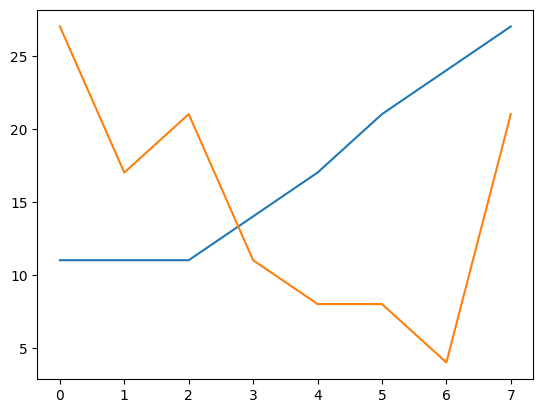

In [166]:
list(map(plt.plot, pd.DataFrame(v).iloc[1].to_frame().values.ravel()))